In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [4]:
df = pd.read_csv('../Data/all_20000_posts.csv', low_memory=False)
df.drop(columns="Unnamed: 0", inplace=True)
df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,crosspost_parent,crosspost_parent_list,edited,poll_data,suggested_sort,is_gallery,author_flair_template_id,link_flair_css_class,gallery_data,media_metadata
0,[],False,amnesiac7,NaN,[],NaN,text,t2_7hi8y,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Bonsai37,NaN,[],NaN,text,t2_8iqzl6l8,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,progress18,NaN,[],NaN,text,t2_nkk56,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,Maxcactus,NaN,[],NaN,text,t2_1vwn,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,SLeeCunningham,NaN,[],NaN,text,t2_6b4upjaa,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['selftext'].isnull().sum()

15196

In [6]:
df['selftext'] = df['selftext'].fillna('')


In [6]:
# df['selftext'].value_counts()

In [7]:
(df['selftext'] == '[removed]').sum()

4172

In [8]:
(df['selftext'] == '[deleted]').sum()

0

In [9]:
# I attempted to replace all of the removed selftexts, but it degreaded the models performance
# df['selftext'] = (df['selftext']).replace('[removed]', '')

In [9]:
df['title_and_st'] = df['title'] + df['selftext']

In [10]:
df.duplicated(subset=None, keep='first').sum()

0

In [11]:
df['subreddit'] = df['subreddit'].map({'Liberal':1, "Conservative":0})

In [12]:
df['post_length'] = df['title_and_st'].apply(len)

In [13]:
df['word_count'] = [len(x.split()) for x in df['title_and_st'].tolist()]

In [14]:
df.groupby('subreddit').mean()

,allow_live_comments,can_mod_post,contest_mode,created_utc,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,...,subreddit_subscribers,thumbnail_height,thumbnail_width,total_awards_received,upvote_ratio,wls,author_flair_background_color,edited,post_length,word_count
subreddit,,,,,,,,,,,,,,,,,,,,,
0,0.0004,0.0,0.0,1.636459e+09,0.528606,0.0,0.002901,0.121724,0.528606,0.113223,...,879403.498300,92.130231,139.848543,0.0006,0.995619,6.987998,NaN,1.635787e+09,80.194239,12.626125
1,0.0022,0.0,0.0,1.610913e+09,0.315932,0.0,0.000000,0.000000,0.315932,0.384538,...,100707.716672,88.233421,139.840770,0.0022,0.991325,6.265927,NaN,1.603427e+09,115.681768,18.427443


In [15]:
X = df['title_and_st']
y = df['subreddit']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [17]:
# #https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
# import nltk

# stopwords = nltk.corpus.stopwords.words('english')
# stopwords.append('removed')
# stopwords.append('deleted')

In [29]:
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2))


In [30]:
X_train_vec = cvec.fit_transform(X_train)

In [31]:
X_test_vec = cvec.transform(X_test)

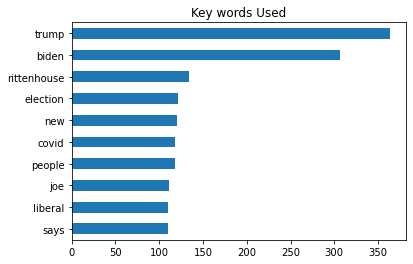

In [53]:
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).sort_values(ascending=True).plot(kind='barh')
plt.title('Key words Used')
plt.savefig('Key words Used', bbox_inches='tight');

In [55]:
X_train_df['lib_or_con'] = y_train.values

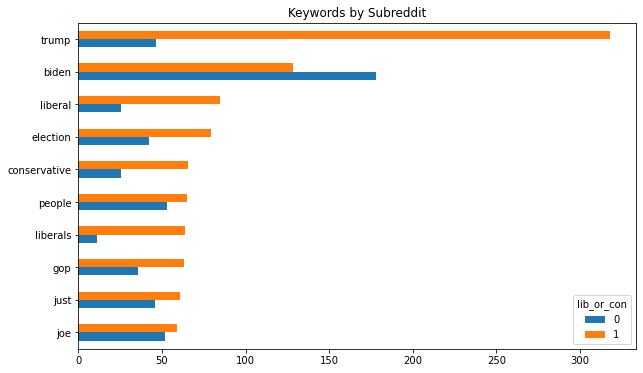

In [56]:
X_train_df.groupby('lib_or_con').sum().T.sort_values(1, 
                                    ascending=False).head(10).sort_values(1).plot(kind='barh', figsize=(10,6)) 
plt.title('Keywords by Subreddit')
plt.savefig('Keywords by Subreddit', bbox_inches='tight')

### Created a KNN pipeline to test in the voting classifier

In [34]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import StandardScaler
# knn_pipe = Pipeline([
#     ('ss', StandardScaler(with_mean=False)),
#     ('knn', KNeighborsClassifier())
# ])

### Created a Voting Clasifier

In [33]:
vote = VotingClassifier([
#     ('ada',AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
#     ('gb', GradientBoostingClassifier()),
#     ('rt', RandomForestClassifier()),
    ('log', LogisticRegression()),
#     ('knn_pipe', knn_pipe),
#     ('tree', DecisionTreeClassifier())
])
params = {
#     'gb__n_estimators': [200],
#     'ada__base_estimator__max_depth': [1, 2, 3],
#     'rt__n_estimators':[200],
    'log__penalty':['l2'],
    'log__C': [.85],
    'log__max_iter': [500, 1000, 1500, 2000],
#     'knn_pipe__knn__n_neighbors': [3, 4, 5, 6]
#     'tree__max_depth': [2,3,5,7],
#     'tree__min_samples_split':[5, 10, 15, 20],
#     'tree__min_samples_leaf':[2, 3, 4, 5, 6],
#     'tree__ccp_alpha':[0, 0.001, 0.01, 0.1, 1, 10]
    
}

gs = GridSearchCV(vote, param_grid=params)
gs.fit(X_train_vec, y_train)
print(gs.best_score_)
gs.best_params_

0.7907582749805491


{'log__C': 0.85, 'log__max_iter': 500, 'log__penalty': 'l2'}

### Used the best parameters of the logistic regression model 

In [34]:
logreg = LogisticRegression(C=.85, max_iter=500)

In [35]:
logreg.fit(X_train_vec, y_train)

LogisticRegression(C=0.85, max_iter=500)

In [36]:
logreg.score(X_train_vec, y_train), logreg.score(X_test_vec, y_test)

(0.9818630392745216, 0.8004)

In [37]:
cross_val_score(logreg, X_train_vec, y_train).mean()

0.7907582749805491

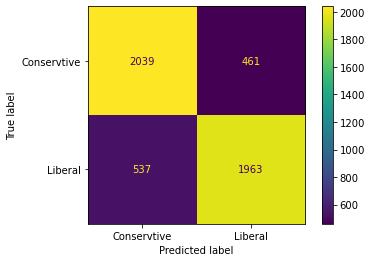

In [57]:
plot_confusion_matrix(logreg, X_test_vec, y_test, display_labels=['Conservtive', 'Liberal'])
plt.savefig('CM - Best Model', bbox_inches='tight');

In [39]:
import sklearn.metrics as metrics


In [40]:
preds = logreg.predict(X_test_vec)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).flatten()

## Sensitvity (recall)

In [41]:
recall = metrics.recall_score(y_test, preds)
recall

0.7852

## Precision

In [42]:
precision = metrics.precision_score(y_test, preds)
precision

0.8098184818481848

## Relationship between Precision and Sensitivity (from nlp-ii lesson)

In [43]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': logreg.predict_proba(X_test_vec)[:,1]})

pred_df.head()

,true_values,pred_probs
11439,0,0.050167
19068,0,0.593741
3955,1,0.684408
8245,1,0.814025
2670,1,0.946403


/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


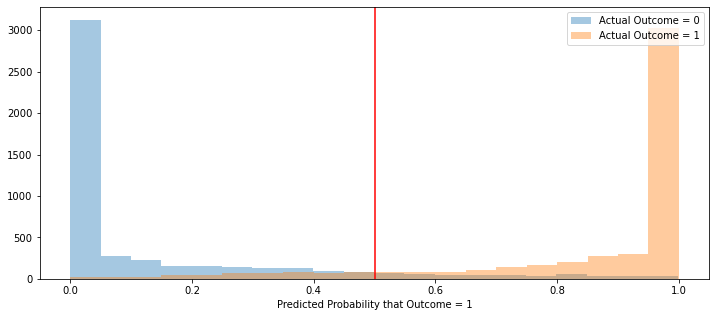

In [44]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.axvline(y.mean(), color='red')
plt.legend();

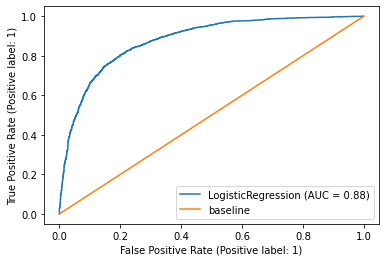

In [58]:
# ROC curve
metrics.plot_roc_curve(logreg, X_test_vec, y_test)
# add worst case scenario line
plt.plot([0,1], [0,1], label="baseline")
# add a legend
plt.legend()
plt.savefig('ROC AUC', bbox_inches='tight');

In [46]:
# Calculate ROC AUC.
metrics.roc_auc_score(y_test, logreg.predict_proba(X_test_vec)[:, 1])

0.8789871199999999

## What posts were predicted to be in the Conserative(0) subreddit but were actually in the Liberal(1) subreddit?

In [47]:
X_test[(y_test != preds) & (preds == 0)]

5423    Keep up the good work, Putin tells spy agency ...
9065    Goplay168 Slot Online, Casino Online, Judi Bol...
8564    Interactive map of who got PPP money. View fro...
4332    UCLA wins $3.65-million grant to build ‘Age of...
1079    FBI Reportedly Finds No Evidence That Jan. 6 W...
                              ...                        
3231             The Five Conceptions of American Liberty
574              MILF Horny Naughty Enjoys with Hairbrush
2022    Whitmire: Alabama lawmaker wants to ban critic...
2500    White House backs bill establishing Jan. 6 com...
2335                                       Save Americans
Name: title_and_st, Length: 537, dtype: object